In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# plt.rc('figure', figsize=(13, 7))
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', size=13)

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')

In [4]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L1.xlsx')

In [10]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [9]:
df.head()

,Year,Period,Area,Ownership,Industry Code,Industry,Level,Establishments,Firms,Average Employment,Average Weekly Wage,Total Wages,Month 1 Employment,Month 2 Employment,Month 3 Employment,Hierarchical Ordering,Total Employment
0,2017,1,Texas,Local Government,1011,Natural Resources and Mining,1,3,3,6,659,51409,6,6,6,8,18
1,2017,1,Texas,Private,1011,Natural Resources and Mining,1,19547,17486,269033,2562,8959344530,266172,269297,271629,8,807099
2,2017,1,Texas,Total All,1011,Natural Resources and Mining,1,19550,17489,269039,2562,8959395939,266178,269303,271635,8,807117
3,2017,2,Texas,Private,1011,Natural Resources and Mining,1,19522,17454,278215,1879,6796444215,274576,278259,281810,8,834645
4,2017,2,Texas,Total All,1011,Natural Resources and Mining,1,19524,17456,278219,1879,6796485889,274580,278263,281814,8,834657


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   817 non-null    int64 
 1   Period                 817 non-null    int64 
 2   Area                   817 non-null    object
 3   Ownership              817 non-null    object
 4   Industry Code          817 non-null    int64 
 5   Industry               817 non-null    object
 6   Level                  817 non-null    int64 
 7   Establishments         817 non-null    int64 
 8   Firms                  817 non-null    int64 
 9   Average Employment     817 non-null    int64 
 10  Average Weekly Wage    817 non-null    int64 
 11  Total Wages            817 non-null    int64 
 12  Month 1 Employment     817 non-null    int64 
 13  Month 2 Employment     817 non-null    int64 
 14  Month 3 Employment     817 non-null    int64 
 15  Hierarchical Ordering  

In [40]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [41]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [43]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

In [53]:
# add a column named quarter and compare to period to see if this workedd
df['Q'] = df.Date.dt.quarter
(df.Q == df.Period).mean()

1.0

In [79]:
# create new df with just totals
total_df = df[df.Ownership == 'Total All']

In [95]:
# take a look at all industries represented
ind_list = total_df.Industry.value_counts().index.tolist()
ind_list

['Trade, Transportation and Utilities',
 'Unclassified',
 'Natural Resources and Mining',
 'Manufacturing',
 'Financial Activities',
 'Public Administration',
 'Education and Health Services',
 'Leisure and Hospitality',
 'Professional and Business Services',
 'Other Services',
 'Construction',
 'Information']

In [83]:
# try for a few industries
nrm_t = total_df[total_df.Industry == 'Natural Resources and Mining']

In [86]:
ttu_t = total_df[total_df.Industry == 'Trade, Transportation and Utilities']

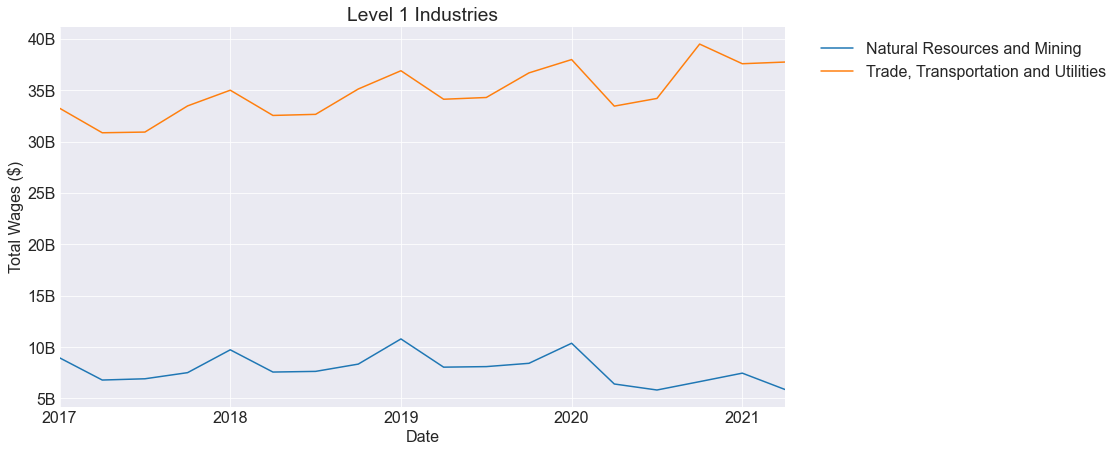

In [93]:
# try to plot total wages over time
nrm_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Natural Resources and Mining')
ttu_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Trade, Transportation and Utilities')
plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

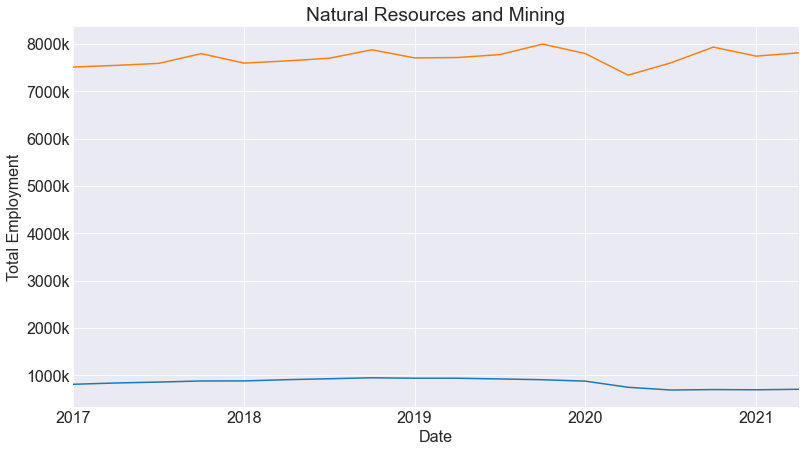

In [104]:
# try to plot total wages over time
nrm_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Natural Resources and Mining')
ttu_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Trade, Transportation and Utilities')
plt.gca().set(ylabel = 'Total Employment', title='Natural Resources and Mining')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

In [96]:
# loop through list of industries and add to dict of dfs with key being industry name
df_dict = {}
for ind in ind_list:
    df_dict[ind] = total_df[total_df.Industry == ind]

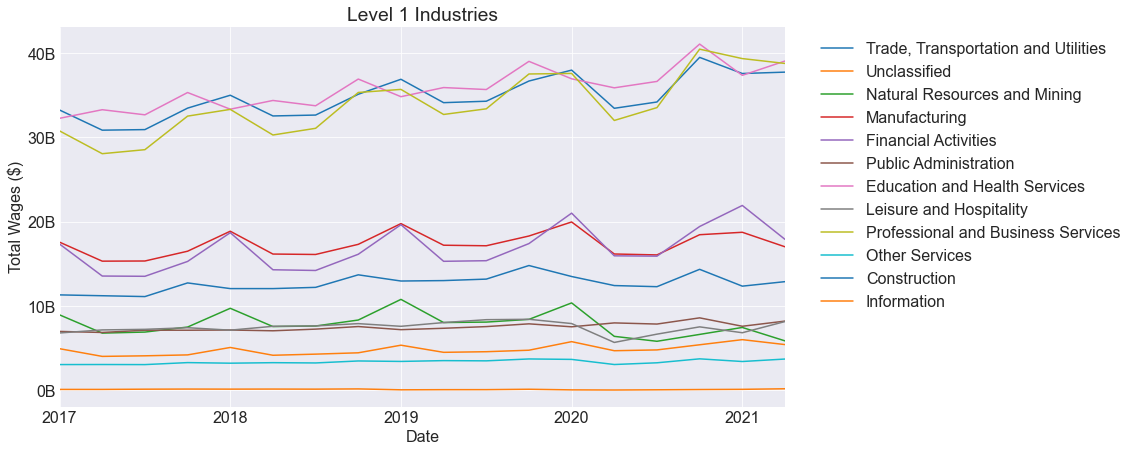

In [101]:
# loop through dictionary to plot all dfs on same plot
for ind in ind_list:
    df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

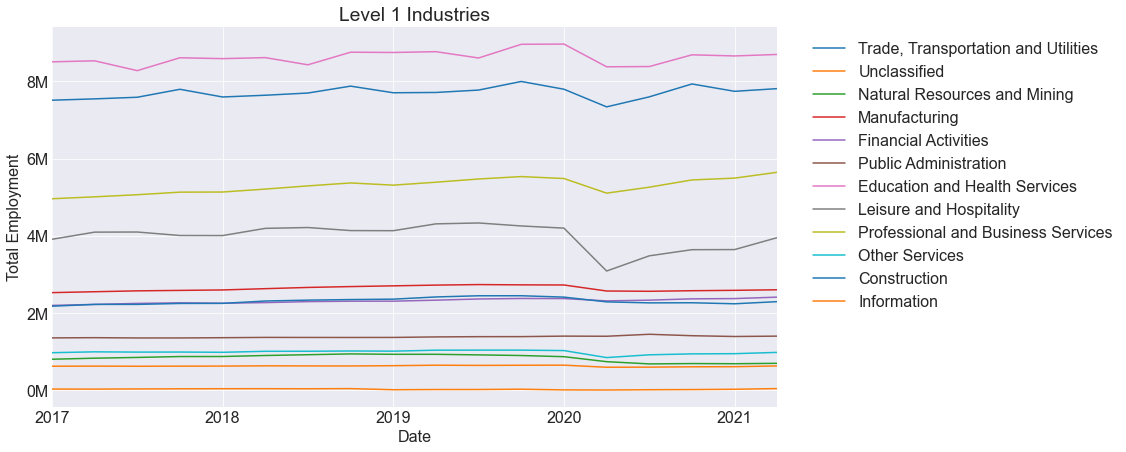

In [107]:
# do the same thing for wages
for ind in ind_list:
    df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

In [148]:
cmap = matplotlib.cm.get_cmap('gist_rainbow')
cmap

In [149]:
len(ind_list)

12

In [150]:
colors = [cmap(i) for i in np.linspace(0, 1, 12)]

In [143]:
matplotlib.pyplot.set_cmap('hsv')

<Figure size 936x504 with 0 Axes>

In [152]:
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 12))

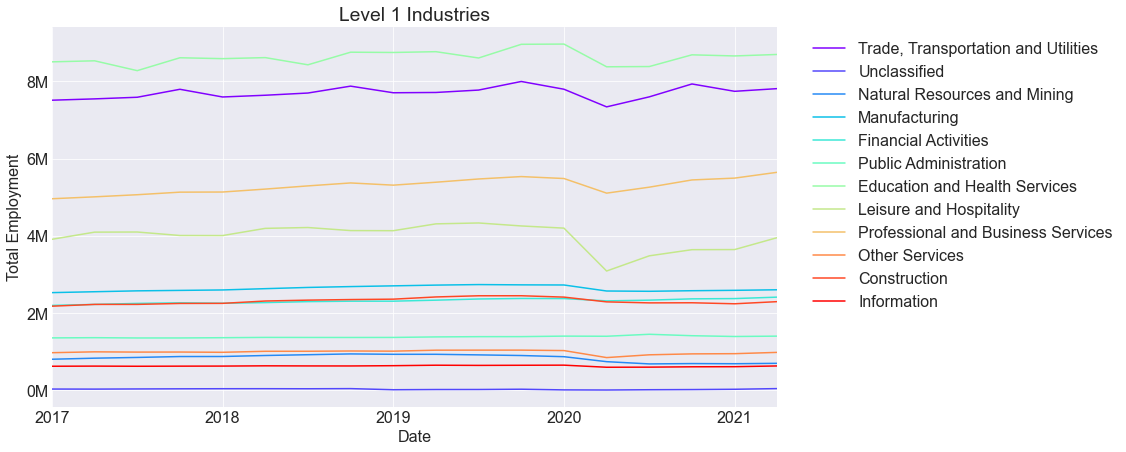

In [153]:
# do the same thing for wages
from cycler import cycler


plt.gca().set_prop_cycle(cycler('color', color))
for ind in ind_list:
    df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

In [109]:
# check matplotlib version
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.3.4
